# Analysis

## Data

The dataset contains 12083 rows and 940 columns. Glancing over the layout file of the dataset provides information about the type of the data. There are regional and demographic information about the household. There are finer details about the house such as type of walls, number of rooms, type of rooms and heating, cooling and insulations used. There are details of electrical appliances used such as number of heaters, bulbs, air conditioning, tv, gaming console, celieng fans etc. Most of the data consists of categorical variables such as type of television while some of the data is numerical such as temperature at night, and number of tv in the household. The goal is to create a simple model which can explain with good accuracy the amount of energy usage provided in 'KWH' column.<br>

<br>
Based on initial intuition, I defined some functions which are used to preprocess the data. The function 'get_countofmax' takes a range of columns as input and gives the details of element with highest occurence in each column. This is used to understand if the column contains high entropy and hence high information variables. For example the column 'STOVEN' stands for number of stoves and contains 88.7% count of '1'. While this information is useful, such columns are discarded for now considering that they contain less randomness, hence would not have affect on building a simpler model. Consequently, I defined a function 'dropcolsinrange' which is used to drop columns in a given range and accept range of the columns and columns to keep in that range. Since, most of the data is in categorical form, I defined a method 'findreplace_incols' to replace missing values in a list of categorical columns with their mode. I defined two functions to encode the categorical columns: 'binaryencode_cols' and 'onehotencode_cols'. First one encodes all columns in a given range in binary form, while the second function encodes columns with cardinality less than 8 to one-hot encoding. Both the functions repalce boolean labels for columns containing two values. Finally, I implemented MAPE(mean absolute percentage error) is a metrics of prediction accuracy in regression problems.<br>
<br>

Loading data is followed by analysis of the distribution of the target variable. It's a somewhat skeId distribution with around 140 rows containing values more than 35k KWH. To lead to a better regularization and avoid effect of outliers on the model, I removed all rows with KWH more than 35,000. The resulting distribution is show in cell 18 above.

## Data Preprocessing

I start by picking a range of columns and analyzing it. The steps followed to preprocess the data were as following: <br>
<br>
1.) Select a range of columns.<br>
2.) Analyze the distribution of variables in the columns using get_countofmax function.<br>
3.) Decide columns to keep based on subjective understanding of its relation to usage of electricity. Drop the obvious collinear columns - for example only TOTROOMS(total no of rooms) was kept in the data and BEDROOMS (no of bedrooms), NCOMBATH(no of combined bathrooms), NHAFBATH(no of half bathrooms), OTHROOMS(other rooms), TOTROOMS were droppped.<br>
4.) Encode categorical variables using the function onehotencode_cols<br>
5.) Drop all the columns starting from Z (since they are imputation flags and not useful here).<br>
<br>
This process is repeated by picking a range of columns till the target variable 'KWH'. Some columns after this contain direct information to compute KWH. For example, summation of a combination of values from columns KWHSPH, KWHCOL, KWHWTH, KWHRFG, KWHOTH directly yields KWH.<br> Also columns which contain cost of electricity and total cost occured contain a direct calculation to KWH. To avoid 'cheating' we drop all such columns to avoid any direct computation.


## Model Building

The curated data is split into 85% train and 15% test set. <br>
I performed PCA on the data followed by linear regression using 130 principal components. The result with such a simple model is impressive with 0.58 R_squared score on train and  0.57 on the test set. This shows that the data did not overfit and regularized well on the test set.<br>
Next, I used random forest regressor on the curated data. A simple grid search was performed to check the best combination of parameters out of an empirical set. This yields an improved result with 0.44 MAPE on train and 0.41 MAPE on test set. The R_squared score is 0.77 on the train set and 0.59 on the test set which is better than the linear regression model.<br>
Finally, I tried a KNN regression with KD_tree algorithm. Though, the MAPE is 0.49 on train and 0.38 on test set, the R_squared score is lesser than random forest regressor in both train and test set.

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

# Utility Functions

In [6]:
#Function to loop over range of columns and give the count of element with highest occurence. 
#This will be used to decide if a column contains useful information

def get_countofmax(df, start_col, end_col):
    try:
        print( 'Column_name   unique_values    frequent_element      frequency      percentage')
        shape = df.shape
        start_col = df.columns.get_loc(start_col)
        end_col = df.columns.get_loc(end_col)
        for i in range(start_col, end_col+1):
            col = data.columns[i]
            unqiue = len(set(data.iloc[:,i]))
            x = (data.iloc[:,i]).value_counts()[:1]
            x1 = x[:1].index.tolist()
            x2 = int(x)
            print( col +str(' : ') +"    " + str(unqiue) +"    " + str(x1) +"    " + str(x2)+"    " + str(x2/shape[0]*100)+'%')
    except Exception as e:
        print(e)

In [7]:
#Function to drop columns in a range with exception of few columns
def dropcolsinrange(df, start_col, end_col, skip_columns = []):
    
    print( 'Dropped columns:')
    try:
        shape = df.shape
        start_col = df.columns.get_loc(start_col)
        end_col = df.columns.get_loc(end_col)
        for i in range(start_col, end_col+1):
            col = data.columns[i]
            if not col in skip_columns:
                print(col)
                df = df.drop([col], axis = 1)
    except Exception as e:
        print(e)    
    
    return df

In [8]:
#fUNCTION to check if a particulat value exists in a list of columns.. Replace with mode if yes

def findreplace_incols(df, col_list, value, replace= False):
    print('Count of ' +str(value)+ " in list of columns:")
    
    if replace:
        print('Values will be replaced by mode.')
        
    try:
        for col in col_list:
            x = df[col].to_list().count(value)
            print(col + str(":   ")+str(x))
            if(x and replace):
                m = df[col].mode()[0]
                df[col].replace(value, m, inplace = True )
    except Exception as e:
        print(e)      

In [9]:
#Encoding of a list of columns using binary encoding
def binaryencode_cols(df, col_list = []):
    if(len(col_list) < 1):
        return

    try:
        #print('here')
        for i in col_list:
            if len(set(df[i])) > 2:
                print('Binary Encoding column ' +str(i))
                #Binary encoding 
                domain_ec = ce.BinaryEncoder(cols = [i])
                dfbin = domain_ec.fit_transform(df[i])
                df = pd.concat([df, dfbin], axis = 1)
                df = df.drop([i], axis = 1)
            else:
                print('Boolean labels for column ' +str(i))
                x = set(df[i])
                df[i].replace(x, (1, 0), inplace=True)
    except Exception as e:
        print(e)     
    return df

In [10]:
#Encoding of a list of columns using onehot encoding if no of columns less than 8
def onehotencode_cols(df, col_list = []):
    if(len(col_list) < 1):
        return

    try:
        #print('here')
        for i in col_list:
            if len(set(df[i])) > 8:
                print('Binary Encoding column ' +str(i))
                #Binary encoding 
                domain_ec = ce.BinaryEncoder(cols = [i])
                dfbin = domain_ec.fit_transform(df[i])
                df = pd.concat([df, dfbin], axis = 1)
                df = df.drop([i], axis = 1)
            elif len(set(df[i])) > 2:
                print('One Hot Encoding column ' +str(i))
                #One hot encoding 
                df = pd.get_dummies(df, columns= [i], prefix=[i], drop_first=True)
            else:
                print('Boolean labels for column ' +str(i))
                x = set(df[i])
                df[i].replace(x, (1, 0), inplace=True)
    except Exception as e:
        print(e)     
    return df

In [5]:
def mean_absolute_percentage_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):

    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape, weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

# Load Data

In [11]:
raw_data = pd.read_csv('recs2009_public.csv')

C:\Users\Manish\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
raw_data.head(5)

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


In [13]:
raw_data.shape

(12083, 940)

In [14]:
#Target variable
y = raw_data['KWH']
y.describe()

count     12083.000000
mean      11288.159398
std        7641.190845
min          17.000000
25%        5837.000000
50%        9623.000000
75%       14765.000000
max      150254.000000
Name: KWH, dtype: float64

<AxesSubplot:ylabel='Frequency'>

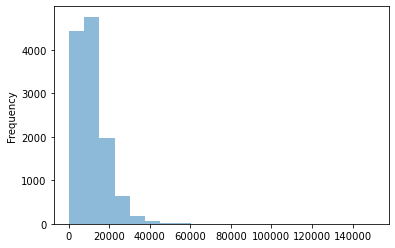

In [15]:
y.plot.hist(bins=20, alpha=0.5)

In [16]:
#How many above 30000
y[y > 30000].count(),y[y > 35000].count(), y[y > 50000].count(), y[y > 75000].count(), y[y > 100000].count()

(297, 140, 29, 2, 1)

## Data Preprocessing

In [17]:
data = raw_data

In [18]:
#Drop columns greater than 35k since it will affect the model
data = data[data['KWH'] < 35000] 
y = data['KWH']

<AxesSubplot:ylabel='Frequency'>

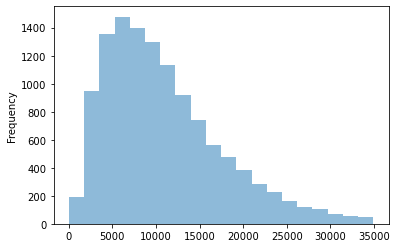

In [19]:
y.plot.hist(bins=20, alpha=0.5)

In [20]:
#Drop DOEID
#Drop first column
data = data.drop('DOEID', axis = 1)

In [21]:
#location and housetype variables
print( 'REGIONC ' + str(set(data['REGIONC']))),  
print( 'DIVISION ' +str(set(data['DIVISION']))), 
print( 'REPORTABLE_DOMAIN ' + str(set(data['REPORTABLE_DOMAIN']))), 
print( 'TYPEHUQ ' + str(set(data['TYPEHUQ'])))

REGIONC {1, 2, 3, 4}
DIVISION {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
REPORTABLE_DOMAIN {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}
TYPEHUQ {1, 2, 3, 4, 5}


In [22]:
#Get distribution of highest occuring element
get_countofmax(data,'REGIONC','TYPEHUQ' )

Column_name   unique_values    frequent_element      frequency      percentage
REGIONC :     4    [3]    4024    33.69337687348237%
DIVISION :     10    [5]    2202    18.43757849786486%
REPORTABLE_DOMAIN :     27    [26]    1598    13.380222724608556%
TYPEHUQ :     5    [2]    7670    64.22171983588713%


In [23]:
data = onehotencode_cols(data,['REGIONC', 'DIVISION','REPORTABLE_DOMAIN', 'TYPEHUQ'])

One Hot Encoding column REGIONC
Binary Encoding column DIVISION


C:\Users\Manish\Miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Binary Encoding column REPORTABLE_DOMAIN


C:\Users\Manish\Miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


One Hot Encoding column TYPEHUQ


In [24]:
data.iloc[:,-20:]

,DesignDBT99,DesignDBT1,REGIONC_2,REGIONC_3,REGIONC_4,DIVISION_0,DIVISION_1,DIVISION_2,DIVISION_3,DIVISION_4,REPORTABLE_DOMAIN_0,REPORTABLE_DOMAIN_1,REPORTABLE_DOMAIN_2,REPORTABLE_DOMAIN_3,REPORTABLE_DOMAIN_4,REPORTABLE_DOMAIN_5,TYPEHUQ_2,TYPEHUQ_3,TYPEHUQ_4,TYPEHUQ_5
0,9,96,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
1,38,73,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
2,12,88,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1
3,7,87,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
4,13,90,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,-3,84,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
12079,26,101,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0
12080,-9,89,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0
12081,13,93,0,0,1,0,0,1,1,1,0,0,1,1,0,0,1,0,0,0


In [25]:
data_x = data.loc[: ,['HDD65','CDD65','HDD30YR','CDD30YR']]
corr = data_x.corr()
print(corr)

            HDD65     CDD65   HDD30YR   CDD30YR
HDD65    1.000000 -0.805770  0.990851 -0.755653
CDD65   -0.805770  1.000000 -0.805528  0.977959
HDD30YR  0.990851 -0.805528  1.000000 -0.768620
CDD30YR -0.755653  0.977959 -0.768620  1.000000


Some correlation here. Let's keep HDD65 and CDD65 since they are specific to year 2009 and drop the other two.

In [26]:
data = data.drop(['HDD30YR','CDD30YR'], axis = 1)

In [27]:
#Climate zones
print("Climate_Region_Pub :" +str( set(raw_data["Climate_Region_Pub"])))
print("AIA_Zone :" +str(set(raw_data["AIA_Zone"])))

#unique values METRO or MICRO homes and UR
set (data['METROMICRO']),set(data['UR'])

Climate_Region_Pub :{1, 2, 3, 4, 5}
AIA_Zone :{1, 2, 3, 4, 5}


({'METRO', 'MICRO', 'NONE'}, {'R', 'U'})

In [28]:
get_countofmax(data,"Climate_Region_Pub",  'UR')

Column_name   unique_values    frequent_element      frequency      percentage
Climate_Region_Pub :     5    [1]    3957    33.13237879929666%
AIA_Zone :     5    [3]    3047    25.512852717072764%
METROMICRO :     3    ['METRO']    10191    85.33031901532279%
UR :     2    ['U']    9584    80.2478439253119%


In [29]:
data = onehotencode_cols(data,["Climate_Region_Pub", "AIA_Zone",'METROMICRO', 'UR'] )

One Hot Encoding column Climate_Region_Pub
One Hot Encoding column AIA_Zone
One Hot Encoding column METROMICRO
Boolean labels for column UR


In [30]:
data.head(5)

,NWEIGHT,HDD65,CDD65,UR,KOWNRENT,CONDCOOP,YEARMADE,YEARMADERANGE,OCCUPYYRANGE,CONVERSION,...,Climate_Region_Pub_2,Climate_Region_Pub_3,Climate_Region_Pub_4,Climate_Region_Pub_5,AIA_Zone_2,AIA_Zone_3,AIA_Zone_4,AIA_Zone_5,METROMICRO_MICRO,METROMICRO_NONE
0,2471.68,4742,1080,1,1,-2,2004,7,8,-2,...,0,0,1,0,0,1,0,0,0,0
1,8599.17,2662,199,1,2,-2,1998,6,8,-2,...,0,0,0,1,0,0,1,0,0,0
2,8969.92,6233,505,1,2,-2,1965,3,7,-2,...,0,0,0,0,1,0,0,0,0,0
3,18003.64,6034,672,1,1,-2,1985,5,5,-2,...,0,0,0,0,1,0,0,0,0,0
4,5999.61,5388,702,1,1,1,1983,5,5,-2,...,0,0,0,0,0,1,0,0,0,0


We will sometimes create a subset of original dataframe, for example *data_x* here to do analysis on a group of variables.

In [31]:
data_x = pd.concat([data.iloc[:,-3:], data['UR']], axis = 1)
data_x.head()

,AIA_Zone_5,METROMICRO_MICRO,METROMICRO_NONE,UR
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [32]:
corr = data_x.corr()
print(corr)

                  AIA_Zone_5  METROMICRO_MICRO  METROMICRO_NONE        UR
AIA_Zone_5          1.000000         -0.031841        -0.022940 -0.000369
METROMICRO_MICRO   -0.031841          1.000000        -0.076656 -0.168868
METROMICRO_NONE    -0.022940         -0.076656         1.000000 -0.332278
UR                 -0.000369         -0.168868        -0.332278  1.000000


MICROMETRO and UR do not seem correlated. Let's keep encoded columns for both.

In [33]:
data = data.drop(['NWEIGHT','KOWNRENT','CONDCOOP','YEARMADE'], axis = 1)

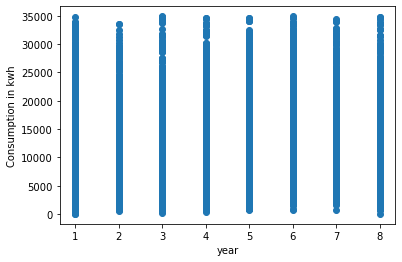

In [34]:
#Does house age affect electricity consumption?
plt.scatter(data['YEARMADERANGE'], data['KWH'])
plt.xlabel('year')
plt.ylabel('Consumption in kwh')
plt.show()

In [35]:
#Let's keep it for now
data = onehotencode_cols(data,['YEARMADERANGE'] )

One Hot Encoding column YEARMADERANGE


In [36]:
data = data.drop(['OCCUPYYRANGE'], axis = 1) #seems irrelevant

From now on, many columns with -2 or 0.  Let's check few columns here.

In [37]:
print( 'CONVERSION ' + str(set(raw_data['CONVERSION']))),  
print( 'ORIG1FAM ' +str(set(raw_data['ORIG1FAM']))), 
print( 'LOOKLIKE ' + str(set(raw_data['LOOKLIKE']))), 
print( 'NUMFLRS ' + str(set(raw_data['NUMFLRS'])))
print( 'NUMAPTS ' + str(set(raw_data['NUMAPTS'])))

CONVERSION {1, 2, -2}
ORIG1FAM {0, 1, -2}
LOOKLIKE {1, 2, -2}
NUMFLRS {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 35, -2}
NUMAPTS {5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 68, 70, 72, 75, 76, 80, 81, 84, 86, 88, 90, 95, 96, 99, 100, 102, 105, 108, 110, 112, 115, 116, 118, 120, 123, 125, 126, 130, 133, 135, 140, 141, 145, 150, 155, 160, 168, 170, 175, 178, 180, 187, 192, 199, 200, 313, 316, 322, 365, -2}


In [38]:
get_countofmax(data, "CONVERSION", "OUTLET")

Column_name   unique_values    frequent_element      frequency      percentage
CONVERSION :     3    [-2]    11018    92.25487733400318%
ORIG1FAM :     3    [-2]    11734    98.25002093276396%
LOOKLIKE :     3    [-2]    11783    98.66030310642218%
NUMFLRS :     19    [-2]    10020    83.89851796031148%
NUMAPTS :     108    [-2]    10020    83.89851796031148%
WALLTYPE :     9    [3]    4069    34.07016662480114%
ROOFTYPE :     9    [5]    5743    48.086745373859166%
STUDIO :     3    [-2]    9095    76.15339529431466%
NAPTFLRS :     4    [-2]    9095    76.15339529431466%
STORIES :     6    [10]    5605    46.93125680314829%
TYPEHUQ4 :     3    [-2]    11405    95.49526919534456%
BEDROOMS :     12    [3]    4816    40.324876496692625%
NCOMBATH :     8    [1]    5516    46.18605040609562%
NHAFBATH :     5    [0]    8524    71.37235200535879%
OTHROOMS :     13    [2]    3616    30.277149794858914%
TOTROOMS :     19    [6]    2353    19.701917441178935%
CELLAR :     3    [0]    5597    46

Looking at above result, most of columns contain a lot of '-2'. There isn't much information which is gained by knowing what value such columns contain. We discard all the columns which contain more than 50% values filled with -2.
The columns which seem to have some meaningful values are: WALLTYPE, ROOFTYPE, STORIES, BEDROOMS, NCOMBATH, OTHROOMS,TOTROOMS , CELLAR, CRAWL, CONCRETE, ATTIC , PRKGPLC1.

In [39]:
colstokeep = ['WALLTYPE', 'ROOFTYPE', 'CELLAR', 'CRAWL','BASEUSE', 'CONCRETE', 'ATTIC','SIZEOFGARAGE', 'PRKGPLC1', 'TOTROOMS']
data = dropcolsinrange(data, "CONVERSION", "OUTLET", colstokeep)

Dropped columns:
CONVERSION
ORIG1FAM
LOOKLIKE
NUMFLRS
NUMAPTS
STUDIO
NAPTFLRS
STORIES
TYPEHUQ4
BEDROOMS
NCOMBATH
NHAFBATH
OTHROOMS
BASEFIN
FINBASERMS
BASEHEAT
BASEHT2
PCTBSTHT
BASECOOL
BASECL2
PCTBSTCL
ATTICFIN
FINATTRMS
ATTCHEAT
ATTCHT2
PCTATTHT
ATTCCOOL
ATTCCL2
PCTATTCL
ATTICUSE
GARGLOC
GARGHEAT
GARGCOOL
PRKGPLC2
SIZEOFDETACH
OUTLET


In [40]:
data['WALLTYPE'].value_counts()

3    4069
1    2930
2    2255
4    1798
7     543
5     189
6     105
9      47
8       7
Name: WALLTYPE, dtype: int64

In [41]:
#Binary encoding for walltype and rooftype
data = onehotencode_cols(data, ['WALLTYPE', 'ROOFTYPE', 'CELLAR', 'CRAWL','BASEUSE', 'CONCRETE', 'ATTIC','SIZEOFGARAGE', 'PRKGPLC1'])

Binary Encoding column WALLTYPE


C:\Users\Manish\Miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Binary Encoding column ROOFTYPE
One Hot Encoding column CELLAR


C:\Users\Manish\Miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


One Hot Encoding column CRAWL
One Hot Encoding column BASEUSE
One Hot Encoding column CONCRETE
One Hot Encoding column ATTIC
One Hot Encoding column SIZEOFGARAGE
One Hot Encoding column PRKGPLC1


In [42]:
data.head()

,HDD65,CDD65,UR,TOTROOMS,ZKOWNRENT,ZCONDCOOP,ZYEARMADE,ZYEARMADERANGE,ZOCCUPYYRANGE,ZCONVERSION,...,BASEUSE_2,CONCRETE_0,CONCRETE_1,ATTIC_0,ATTIC_1,SIZEOFGARAGE_1,SIZEOFGARAGE_2,SIZEOFGARAGE_3,PRKGPLC1_0,PRKGPLC1_1
0,4742,1080,1,9,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
1,2662,199,1,4,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
2,6233,505,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6034,672,1,7,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
4,5388,702,1,5,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [43]:
#Drop columns from ZKOWNRENT to ZSIZEOFDETACH
data = dropcolsinrange(data, "ZKOWNRENT","ZSIZEOFDETACH")
data.head()

Dropped columns:
ZKOWNRENT
ZCONDCOOP
ZYEARMADE
ZYEARMADERANGE
ZOCCUPYYRANGE
ZCONVERSION
ZORIG1FAM
ZLOOKLIKE
ZNUMFLRS
ZNUMAPTS
ZWALLTYPE
ZROOFTYPE
ZSTUDIO
ZNAPTFLRS
ZSTORIES
ZTYPEHUQ4
ZBEDROOMS
ZNCOMBATH
ZNHAFBATH
ZOTHROOMS
ZCELLAR
ZCRAWL
ZCONCRETE
ZBASEFIN
ZFINBASERMS
ZBASEHEAT
ZBASEHT2
ZPCTBSTHT
ZBASECOOL
ZBASECL2
ZPCTBSTCL
ZBASEUSE
ZATTIC
ZATTICFIN
ZFINATTRMS
ZATTCHEAT
ZATTCHT2
ZPCTATTHT
ZATTCCOOL
ZPCTATTCL
ZATTCCL2
ZATTICUSE
ZPRKGPLC1
ZSIZEOFGARAGE
ZGARGLOC
ZGARGHEAT
ZGARGCOOL
ZPRKGPLC2
ZSIZEOFDETACH


,HDD65,CDD65,UR,TOTROOMS,STOVEN,STOVENFUEL,STOVE,STOVEFUEL,OVEN,OVENFUEL,...,BASEUSE_2,CONCRETE_0,CONCRETE_1,ATTIC_0,ATTIC_1,SIZEOFGARAGE_1,SIZEOFGARAGE_2,SIZEOFGARAGE_3,PRKGPLC1_0,PRKGPLC1_1
0,4742,1080,1,9,1,5,0,-2,0,-2,...,0,1,0,1,0,0,1,0,0,1
1,2662,199,1,4,1,1,0,-2,0,-2,...,0,1,0,1,0,0,1,0,0,1
2,6233,505,1,2,1,1,0,-2,0,-2,...,0,0,0,0,0,0,0,0,0,0
3,6034,672,1,7,0,-2,1,5,1,5,...,0,1,0,1,0,0,1,0,0,1
4,5388,702,1,5,1,5,0,-2,0,-2,...,0,1,0,1,0,0,0,0,1,0


In [44]:
get_countofmax(data, "STOVEN", "HELPDWY")

Column_name   unique_values    frequent_element      frequency      percentage
STOVEN :     4    [1]    10588    88.65444193251277%
STOVENFUEL :     5    [5]    6570    55.011303692539556%
STOVE :     3    [0]    10520    88.08507075274218%
STOVEFUEL :     4    [-2]    10520    88.08507075274218%
OVEN :     4    [0]    10493    87.85899690195093%
OVENFUEL :     4    [-2]    10493    87.85899690195093%
OVENUSE :     8    [4]    4196    35.13355103407854%
OVENCLN :     3    [1]    7464    62.49686008540568%
TYPECLN :     3    [2]    6746    56.48497027547518%
MICRO :     2    [1]    11476    96.08975969186972%
AMTMICRO :     5    [3]    4142    34.681403332496025%
DEFROST :     3    [0]    6445    53.964665494431884%
OUTGRILL :     2    [1]    7256    60.7552541237545%
OUTGRILLFUEL :     4    [-2]    4687    39.2447458762455%
TOPGRILL :     2    [0]    11785    98.6770493175919%
STGRILA :     5    [-2]    11785    98.6770493175919%
TOASTER :     2    [0]    7521    62.97412710374278%
NUM

#### Selecting columns in which -2 is not the most frequently occuring value, and ignoring the obvious collinear columns.

In [45]:
colstokeep = ['STOVENFUEL','OVENUSE','AMTMICRO','OUTGRILLFUEL',
              'TOASTER','NUMMEAL','FUELFOOD','COFFEE','NUMFRIG','SIZRFRI1', 'DWASHUSE']

In [46]:
data = dropcolsinrange(data, "STOVEN", "HELPDWY", colstokeep)

Dropped columns:
STOVEN
STOVE
STOVEFUEL
OVEN
OVENFUEL
OVENCLN
TYPECLN
MICRO
DEFROST
OUTGRILL
TOPGRILL
STGRILA
TYPERFR1
REFRIGT1
ICE
AGERFRI1
ESFRIG
REPLCFRI
HELPFRI
HELPFRIY
TYPERFR2
SIZRFRI2
REFRIGT2
MONRFRI2
AGERFRI2
ESFRIG2
TYPERFR3
SIZRFRI3
REFRIGT3
MONRFRI3
AGERFRI3
ESFRIG3
SEPFREEZ
NUMFREEZ
UPRTFRZR
SIZFREEZ
FREEZER
AGEFRZR
REPLCFRZ
HELPFRZ
HELPFRZY
UPRTFRZR2
SIZFREEZ2
FREEZER2
AGEFRZR2
DISHWASH
AGEDW
ESDISHW
REPLCDW
HELPDW
HELPDWY


In [47]:
data['OUTGRILLFUEL'].value_counts()

-2     4687
 2     4448
 21    2328
 1      480
Name: OUTGRILLFUEL, dtype: int64

In [48]:
raw_data['FUELFOOD'].value_counts() #21 seems like a valid fuel

 5     7344
 1     4109
 2      474
-2      143
 21      13
Name: FUELFOOD, dtype: int64

In [49]:
data = onehotencode_cols(data, colstokeep)

One Hot Encoding column STOVENFUEL
One Hot Encoding column OVENUSE
One Hot Encoding column AMTMICRO
One Hot Encoding column OUTGRILLFUEL
Boolean labels for column TOASTER
One Hot Encoding column NUMMEAL
One Hot Encoding column FUELFOOD
Boolean labels for column COFFEE
One Hot Encoding column NUMFRIG
One Hot Encoding column SIZRFRI1
One Hot Encoding column DWASHUSE


In [50]:
data.head()

,HDD65,CDD65,UR,TOTROOMS,TOASTER,COFFEE,ZSTOVEN,ZSTOVENFUEL,ZSTOVE,ZSTOVEFUEL,...,SIZRFRI1_1,SIZRFRI1_2,SIZRFRI1_3,SIZRFRI1_4,SIZRFRI1_5,DWASHUSE_11,DWASHUSE_12,DWASHUSE_13,DWASHUSE_20,DWASHUSE_30
0,4742,1080,1,9,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,2662,199,1,4,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,6233,505,1,2,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,6034,672,1,7,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,5388,702,1,5,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [51]:
#Drop columns from ZSTOVE to ZAGEDW
data = dropcolsinrange(data,"ZSTOVE", "ZAGEDW")
data.head()

Dropped columns:
ZSTOVE
ZSTOVEFUEL
ZOVEN
ZOVENFUEL
ZOVENUSE
ZOVENCLN
ZTYPECLN
ZMICRO
ZAMTMICRO
ZDEFROST
ZOUTGRILL
ZOUTGRILLFUEL
ZTOPGRILL
ZSTGRILA
ZTOASTER
ZNUMMEAL
ZFUELFOOD
ZCOFFEE
ZNUMFRIG
ZTYPERFR1
ZSIZRFRI1
ZREFRIGT1
ZICE
ZAGERFRI1
ZTYPERFR2
ZSIZRFRI2
ZREFRIGT2
ZMONRFRI2
ZAGERFRI2
ZTYPERFR3
ZSIZRFRI3
ZREFRIGT3
ZMONRFRI3
ZAGERFRI3
ZSEPFREEZ
ZNUMFREEZ
ZUPRTFRZR
ZSIZFREEZ
ZFREEZER
ZAGEFRZR
ZUPRTFRZR2
ZSIZFREEZ2
ZFREEZER2
ZAGEFRZR2
ZDISHWASH
ZDWASHUSE
ZAGEDW


,HDD65,CDD65,UR,TOTROOMS,TOASTER,COFFEE,ZSTOVEN,ZSTOVENFUEL,CWASHER,TOPFRONT,...,SIZRFRI1_1,SIZRFRI1_2,SIZRFRI1_3,SIZRFRI1_4,SIZRFRI1_5,DWASHUSE_11,DWASHUSE_12,DWASHUSE_13,DWASHUSE_20,DWASHUSE_30
0,4742,1080,1,9,1,0,0,0,1,2,...,0,0,0,1,0,0,0,1,0,0
1,2662,199,1,4,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
2,6233,505,1,2,1,1,0,0,0,-2,...,0,0,1,0,0,0,0,0,0,0
3,6034,672,1,7,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,1,0
4,5388,702,1,5,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,1


In [52]:
get_countofmax(data, "CWASHER", "CHRGPLGE")

Column_name   unique_values    frequent_element      frequency      percentage
CWASHER :     2    [1]    9893    82.83513355103408%
TOPFRONT :     3    [1]    8013    67.09369505149459%
WASHLOAD :     6    [2]    4341    36.34765134388345%
WASHTEMP :     4    [2]    4736    39.655028049903706%
RNSETEMP :     4    [3]    7965    66.69178598342125%
AGECWASH :     7    [3]    3339    27.957799547852296%
ESCWASH :     5    [-2]    4694    39.30335761533953%
REPLCCW :     4    [-2]    8357    69.97404337268694%
HELPCW :     7    [-2]    8831    73.94289541991125%
HELPCWY :     8    [-2]    11597    97.10290546763794%
DRYER :     2    [1]    9584    80.2478439253119%
DRYRFUEL :     4    [5]    7603    63.66072176170141%
DRYRUSE :     4    [1]    7862    65.82935610818052%
AGECDRYER :     7    [3]    3233    27.070250355856988%
TVCOLOR :     12    [2]    3946    33.040274637863185%
TVSIZE1 :     4    [2]    5598    46.87264506405426%
TVTYPE1 :     6    [1]    5182    43.389433140751905%
CABLE

#### Selecting columns in which -2 is not the most frequently occuring value, and ignoring the obvious collinear columns.


In [53]:
colstokeep = ['WASHLOAD','WASHTEMP','DRYER','TVCOLOR','TVSIZE1','TVTYPE1','PLAYSTA1','DVD1','TVONWD1',
              'TVONWE1', 'TVONWEWATCH1','TVONWD2' , 'TVONWE2', 'PCPRINT','STEREO', 
              'NUMPC','PCTYPE1','TIMEON1','INTERNET','WELLPUMP','BATTOOLS','BATCHRG']

In [54]:
data = dropcolsinrange(data, "CWASHER", "CHRGPLGE", colstokeep)

Dropped columns:
CWASHER
TOPFRONT
RNSETEMP
AGECWASH
ESCWASH
REPLCCW
HELPCW
HELPCWY
DRYRFUEL
DRYRUSE
AGECDRYER
CABLESAT1
COMBODVR1
DVR1
DIGITSTB1
COMBOVCRDVD1
VCR1
TVAUDIOSYS1
OTHERSTB1
TVONWDWATCH1
TVSIZE2
TVTYPE2
CABLESAT2
COMBODVR2
DVR2
DIGITSTB2
PLAYSTA2
COMBOVCRDVD2
VCR2
DVD2
TVAUDIOSYS2
OTHERSTB2
TVONWDWATCH2
TVONWEWATCH2
TVSIZE3
TVTYPE3
CABLESAT3
COMBODVR3
DVR3
DIGITSTB3
PLAYSTA3
COMBOVCRDVD3
VCR3
DVD3
TVAUDIOSYS3
OTHERSTB3
TVONWD3
TVONWDWATCH3
TVONWE3
TVONWEWATCH3
COMPUTER
MONITOR1
PCONOFF1
PCSLEEP1
PCTYPE2
MONITOR2
TIMEON2
PCONOFF2
PCSLEEP2
PCTYPE3
MONITOR3
TIMEON3
PCONOFF3
PCSLEEP3
INDIALUP
INDSL
INCABLE
INSATEL
INWIRELESS
FAX
COPIER
DIPSTICK
SWAMPCOL
AQUARIUM
NOCORD
ANSMACH
CHRGPLGT
ELECDEV
ELECCHRG
CHRGPLGE


In [55]:
data = onehotencode_cols(data, colstokeep)

One Hot Encoding column WASHLOAD
One Hot Encoding column WASHTEMP
Boolean labels for column DRYER
Binary Encoding column TVCOLOR


C:\Users\Manish\Miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


One Hot Encoding column TVSIZE1
One Hot Encoding column TVTYPE1
One Hot Encoding column PLAYSTA1
One Hot Encoding column DVD1
One Hot Encoding column TVONWD1
One Hot Encoding column TVONWE1
One Hot Encoding column TVONWEWATCH1
One Hot Encoding column TVONWD2
One Hot Encoding column TVONWE2
One Hot Encoding column PCPRINT
Boolean labels for column STEREO
Binary Encoding column NUMPC


C:\Users\Manish\Miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


One Hot Encoding column PCTYPE1
One Hot Encoding column TIMEON1
One Hot Encoding column INTERNET
One Hot Encoding column WELLPUMP
One Hot Encoding column BATTOOLS
One Hot Encoding column BATCHRG


In [56]:
data.head()

,HDD65,CDD65,UR,TOTROOMS,TOASTER,COFFEE,ZSTOVEN,ZSTOVENFUEL,DRYER,STEREO,...,INTERNET_0,INTERNET_1,WELLPUMP_0,WELLPUMP_1,BATTOOLS_1,BATTOOLS_2,BATTOOLS_3,BATCHRG_1,BATCHRG_2,BATCHRG_3
0,4742,1080,1,9,1,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0
1,2662,199,1,4,1,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
2,6233,505,1,2,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,6034,672,1,7,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4,5388,702,1,5,1,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0


In [57]:
#Drop columns from ZCWASHER to ZCHRGPLGE
data = dropcolsinrange(data,"ZCWASHER", "ZCHRGPLGE")

Dropped columns:
ZCWASHER
ZTOPFRONT
ZWASHLOAD
ZWASHTEMP
ZRNSETEMP
ZAGECWASH
ZDRYER
ZDRYRFUEL
ZDRYRUSE
ZAGECDRYER
ZTVCOLOR
ZTVSIZE1
ZTVTYPE1
ZCABLESAT1
ZCOMBODVR1
ZDVR1
ZDIGITSTB1
ZPLAYSTA1
ZCOMBOVCRDVD1
ZVCR1
ZDVD1
ZTVAUDIOSYS1
ZOTHERSTB1
ZTVONWD1
ZTVONWDWATCH1
ZTVONWE1
ZTVONWEWATCH1
ZTVSIZE2
ZTVTYPE2
ZCABLESAT2
ZCOMBODVR2
ZDVR2
ZDIGITSTB2
ZPLAYSTA2
ZCOMBOVCRDVD2
ZVCR2
ZDVD2
ZTVAUDIOSYS2
ZOTHERSTB2
ZTVONWD2
ZTVONWDWATCH2
ZTVONWE2
ZTVONWEWATCH2
ZTVSIZE3
ZTVTYPE3
ZCABLESAT3
ZCOMBODVR3
ZDVR3
ZDIGITSTB3
ZPLAYSTA3
ZCOMBOVCRDVD3
ZVCR3
ZDVD3
ZTVAUDIOSYS3
ZOTHERSTB3
ZTVONWD3
ZTVONWDWATCH3
ZTVONWE3
ZTVONWEWATCH3
ZCOMPUTER
ZNUMPC
ZPCTYPE1
ZMONITOR1
ZTIMEON1
ZPCONOFF1
ZPCSLEEP1
ZPCTYPE2
ZMONITOR2
ZTIMEON2
ZPCONOFF2
ZPCSLEEP2
ZPCTYPE3
ZMONITOR3
ZTIMEON3
ZPCONOFF3
ZPCSLEEP3
ZINTERNET
ZINDIALUP
ZINDSL
ZINCABLE
ZINSATEL
ZINWIRELESS
ZPCPRINT
ZFAX
ZCOPIER
ZWELLPUMP
ZDIPSTICK
ZSWAMPCOL
ZAQUARIUM
ZSTEREO
ZNOCORD
ZANSMACH
ZBATTOOLS
ZBATCHRG
ZCHRGPLGT
ZELECDEV
ZELECCHRG
ZCHRGPLGE


In [58]:
get_countofmax(data, "HEATHOME", "USEMOISTURE")

Column_name   unique_values    frequent_element      frequency      percentage
HEATHOME :     2    [1]    11501    96.29908733149125%
DNTHEAT :     3    [-2]    11501    96.29908733149125%
EQUIPNOHEAT :     11    [-2]    11649    97.53830695805074%
FUELNOHEAT :     7    [-2]    11649    97.53830695805074%
EQUIPM :     13    [3]    7477    62.60571045800888%
FUELHEAT :     10    [1]    5877    49.208741522230596%
MAINTHT :     3    [0]    6901    57.78280164112869%
EQUIPAGE :     7    [5]    2873    24.055932345306875%
REPLCHT :     4    [-2]    9351    78.29691032403917%
HELPHT :     9    [-2]    6394    53.53763710960395%
HELPHTY :     9    [-2]    11433    95.72971615172068%
HEATOTH :     3    [0]    10623    88.94750062798292%
EQUIPAUX :     3    [0]    7028    58.84618605040609%
REVERSE :     3    [0]    11371    95.21058360545926%
WARMAIR :     3    [0]    11238    94.09696056267269%
FURNFUEL :     6    [-2]    11680    97.79787323118144%
STEAMR :     3    [0]    11443    95.81344

In [59]:
colstokeep= ['FUELHEAT','EQUIPAUX','CARRYEL','DIFEQUIP','HEATROOM',
             'NUMTHERM','PROTHERM', 'TEMPHOME','TEMPNITE','MOISTURE']

In [60]:
data = dropcolsinrange(data, "HEATHOME", "USEMOISTURE", colstokeep)

Dropped columns:
HEATHOME
DNTHEAT
EQUIPNOHEAT
FUELNOHEAT
EQUIPM
MAINTHT
EQUIPAGE
REPLCHT
HELPHT
HELPHTY
HEATOTH
REVERSE
WARMAIR
FURNFUEL
STEAMR
RADFUEL
PERMELEC
PIPELESS
PIPEFUEL
ROOMHEAT
RMHTFUEL
WOODKILN
HSFUEL
CARRYKER
CHIMNEY
FPFUEL
NGFPFLUE
USENGFP
RANGE
RNGFUEL
DIFFUEL
EQMAMT
THERMAIN
AUTOHEATNITE
AUTOHEATDAY
TEMPGONE
USEMOISTURE


In [61]:
colstoencode = ['FUELHEAT','EQUIPAUX','CARRYEL','PROTHERM','MOISTURE'] #Encode except temperature and heatroom column

In [62]:
data = onehotencode_cols(data, colstoencode)

Binary Encoding column FUELHEAT


C:\Users\Manish\Miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


One Hot Encoding column EQUIPAUX
One Hot Encoding column CARRYEL
One Hot Encoding column PROTHERM
Boolean labels for column MOISTURE


In [63]:
data = dropcolsinrange(data, "ZHEATHOME", "ZUSEMOISTURE")

Dropped columns:
ZHEATHOME
ZDNTHEAT
ZEQUIPNOHEAT
ZFUELNOHEAT
ZEQUIPM
ZFUELHEAT
ZMAINTHT
ZEQUIPAGE
ZHEATOTH
ZFURNFUEL
ZRADFUEL
ZPIPEFUEL
ZRMHTFUEL
ZHSFUEL
ZFPFUEL
ZNGFPFLUE
ZUSENGFP
ZRNGFUEL
ZDIFFUEL
ZEQMAMT
ZHEATROOM
ZTHERMAIN
ZNUMTHERM
ZPROTHERM
ZAUTOHEATNITE
ZAUTOHEATDAY
ZTEMPHOME
ZTEMPGONE
ZTEMPNITE
ZMOISTURE
ZUSEMOISTURE


In [64]:
get_countofmax(data,"NUMH2ONOTNK", "WHEATAGE2")

Column_name   unique_values    frequent_element      frequency      percentage
NUMH2ONOTNK :     4    [0]    11567    96.8517123000921%
NUMH2OHTRS :     5    [1]    11343    94.97613664908314%
H2OTYPE1 :     3    [1]    11591    97.05266683412877%
FUELH2O :     9    [1]    6350    53.16922046387005%
WHEATOTH :     3    [0]    10574    88.5372184543247%
WHEATSIZ :     4    [2]    6052    50.67403499958134%
WHEATAGE :     7    [3]    3728    31.214937620363393%
WHEATBKT :     3    [0]    10072    84.33391945072427%
HELPWH :     7    [-2]    10402    87.09704429372854%
HELPWHY :     8    [-2]    11862    99.32177844762623%
H2OTYPE2 :     3    [-2]    11589    97.03592062295905%
FUELH2O2 :     8    [-2]    11590    97.04429372854392%
WHEATSIZ2 :     4    [-2]    11650    97.5466800636356%
WHEATAGE2 :     7    [-2]    11589    97.03592062295905%


In [65]:
colstokeep = ['FUELH2O','WHEATSIZ']

In [66]:
data = dropcolsinrange(data, "NUMH2ONOTNK", "WHEATAGE2", colstokeep)

Dropped columns:
NUMH2ONOTNK
NUMH2OHTRS
H2OTYPE1
WHEATOTH
WHEATAGE
WHEATBKT
HELPWH
HELPWHY
H2OTYPE2
FUELH2O2
WHEATSIZ2
WHEATAGE2


In [67]:
data = onehotencode_cols(data, colstokeep)

Binary Encoding column FUELH2O
One Hot Encoding column WHEATSIZ


C:\Users\Manish\Miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [68]:
data = dropcolsinrange(data, "ZNUMH2ONOTNK", "ZWHEATAGE2")

Dropped columns:
ZNUMH2ONOTNK
ZH2OTYPE1
ZFUELH2O
ZWHEATOTH
ZWHEATSIZ
ZWHEATAGE
ZWHEATBKT
ZH2OTYPE2
ZFUELH2O2
ZWHEATSIZ2
ZWHEATAGE2


In [69]:
get_countofmax(data, "AIRCOND", "USENOTMOIST")

Column_name   unique_values    frequent_element      frequency      percentage
AIRCOND :     2    [1]    9806    82.10667336515114%
DNTAC :     3    [-2]    9806    82.10667336515114%
COOLTYPENOAC :     4    [-2]    11416    95.58737335677803%
COOLTYPE :     4    [1]    7168    60.01842083228669%
DUCTS :     3    [-2]    11496    96.25722180356694%
CENACHP :     3    [0]    6022    50.4228418320355%
ACOTHERS :     3    [0]    7121    59.62488486979821%
MAINTAC :     3    [-2]    4626    38.73398643556895%
AGECENAC :     7    [-2]    4626    38.73398643556895%
REPLCCAC :     4    [-2]    10254    85.85782466716906%
HELPCAC :     8    [-2]    8356    69.96567026710207%
HELPCACY :     8    [-2]    11647    97.52156074688102%
ACROOMS :     19    [-2]    4626    38.73398643556895%
USECENAC :     4    [-2]    4626    38.73398643556895%
THERMAINAC :     3    [1]    7172    60.05191325462614%
PROTHERMAC :     3    [-2]    4771    39.94808674537386%
AUTOCOOLNITE :     3    [-2]    8363    70.02

In [70]:
colstokeep = ['DNTAC','COOLTYPE','CENACHP','ACOTHERS','ACROOMS','USECENAC',
              'PROTHERMAC','TEMPHOMEAC','TEMPNITEAC','NUMBERAC','NUMCFAN','USECFAN','TREESHAD','NOTMOIST']

In [71]:
data = dropcolsinrange(data, "AIRCOND", "USENOTMOIST", colstokeep)

Dropped columns:
AIRCOND
COOLTYPENOAC
DUCTS
MAINTAC
AGECENAC
REPLCCAC
HELPCAC
HELPCACY
THERMAINAC
AUTOCOOLNITE
AUTOCOOLDAY
TEMPGONEAC
WWACAGE
ESWWAC
REPLCWWAC
HELPWWAC
HELPWWACY
USEWWAC
USENOTMOIST


In [72]:
colstoencode = ['COOLTYPE','CENACHP','ACOTHERS','ACROOMS','USECENAC',
              'PROTHERMAC','ESWWAC','USECFAN','TREESHAD','NOTMOIST']

In [73]:
data = onehotencode_cols(data, colstoencode)

One Hot Encoding column COOLTYPE
One Hot Encoding column CENACHP
One Hot Encoding column ACOTHERS
Binary Encoding column ACROOMS
One Hot Encoding column USECENAC


C:\Users\Manish\Miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


One Hot Encoding column PROTHERMAC
'ESWWAC'


In [74]:
data = dropcolsinrange(data, "ZAIRCOND", "ZUSENOTMOIST")

Dropped columns:
ZAIRCOND
ZDNTAC
ZCOOLTYPENOAC
ZCOOLTYPE
ZDUCTS
ZCENACHP
ZACOTHERS
ZMAINTAC
ZAGECENAC
ZUSECENAC
ZACROOMS
ZTHERMAINAC
ZPROTHERMAC
ZAUTOCOOLNITE
ZAUTOCOOLDAY
ZTEMPHOMEAC
ZTEMPGONEAC
ZTEMPNITEAC
ZNUMBERAC
ZWWACAGE
ZUSEWWAC
ZNUMCFAN
ZUSECFAN
ZTREESHAD
ZNOTMOIST
ZUSENOTMOIST


In [75]:
get_countofmax(data, "HIGHCEIL", "HELPAUDY")

Column_name   unique_values    frequent_element      frequency      percentage
HIGHCEIL :     3    [0]    8063    67.51235033073768%
CATHCEIL :     3    [-2]    8601    72.01708113539311%
SWIMPOOL :     3    [0]    7728    64.7073599598091%
POOL :     3    [-2]    11114    93.05869547014987%
FUELPOOL :     7    [-2]    11740    98.30025956627313%
RECBATH :     2    [0]    11297    94.59097379217953%
FUELTUB :     7    [-2]    11297    94.59097379217953%
LGT12 :     19    [0]    9333    78.14619442351169%
LGT12EE :     16    [-2]    9333    78.14619442351169%
LGT4 :     24    [0]    4303    36.029473331658714%
LGT4EE :     21    [-2]    4303    36.029473331658714%
LGT1 :     32    [2]    3229    27.036757933517542%
LGT1EE :     28    [0]    4074    34.11203215272545%
NOUTLGTNT :     16    [0]    5772    48.32956543582014%
LGTOEE :     15    [-2]    9158    76.68090094616093%
NGASLIGHT :     4    [-2]    9158    76.68090094616093%
INSTLCFL :     5    [1]    6481    54.266097295486894%
HE

In [76]:
colstokeep = ['HIGHCEIL','CATHCEIL','LGT12','LGT4','LGT1','LGTOEE','INSTLCFL'
              'TYPEGLASS','DOOR1SUM','WINDOWS','ADQINSUL','INSTLINS','DRAFTY','INSTLWS']

In [77]:
data = dropcolsinrange(data, "HIGHCEIL", "HELPAUDY", colstokeep)

Dropped columns:
SWIMPOOL
POOL
FUELPOOL
RECBATH
FUELTUB
LGT12EE
LGT4EE
LGT1EE
NOUTLGTNT
NGASLIGHT
INSTLCFL
HELPCFL
HELPCFLY
SLDDRS
TYPEGLASS
NEWGLASS
HELPWIN
HELPWINY
AGEINS
HELPINS
HELPINSY
AGEWS
HELPWS
HELPWSY
AUDIT
AGEAUD
HELPAUD
HELPAUDY


In [78]:
colstoencode = ['HIGHCEIL','CATHCEIL','ADQINSUL','INSTLINS','DRAFTY','INSTLWS']

In [80]:
data = onehotencode_cols(data,colstoencode)

One Hot Encoding column HIGHCEIL
One Hot Encoding column CATHCEIL
One Hot Encoding column ADQINSUL
Boolean labels for column INSTLINS
One Hot Encoding column DRAFTY
Boolean labels for column INSTLWS


In [81]:
data = dropcolsinrange(data, "ZHIGHCEIL", "ZAGEAUD")

Dropped columns:
ZHIGHCEIL
ZCATHCEIL
ZSWIMPOOL
ZPOOL
ZFUELPOOL
ZRECBATH
ZFUELTUB
ZLGT12
ZLGT4
ZLGT1
ZNOUTLGTNT
ZNGASLIGHT
ZSLDDRS
ZDOOR1SUM
ZWINDOWS
ZTYPEGLASS
ZNEWGLASS
ZADQINSUL
ZINSTLINS
ZAGEINS
ZDRAFTY
ZINSTLWS
ZAGEWS
ZAUDIT
ZAGEAUD


In [82]:
get_countofmax(data, "USEEL", "NUMCORDS") 
#Error because numcords is not strict numerical columns. This can be ignored for now as its not important for prediction.

Column_name   unique_values    frequent_element      frequency      percentage
USEEL :     1    [1]    11943    100.0%
USENG :     2    [1]    7444    62.329397973708446%
USELP :     2    [0]    6812    57.03759524407602%
USEFO :     2    [0]    11047    92.49769739596417%
USEKERO :     2    [0]    11777    98.61006447291301%
USEWOOD :     2    [0]    10541    88.26090597002428%
USESOLAR :     2    [0]    11802    98.81939211253454%
USEOTH :     2    [0]    9497    79.51938373942895%
ELWARM :     2    [1]    6043    50.59867704931759%
ELECAUX :     2    [0]    9142    76.54693125680315%
ELCOOL :     2    [1]    9806    82.10667336515114%
ELWATER :     2    [0]    7234    60.571045800887546%
ELFOOD :     2    [1]    7567    63.3592899606464%
ELOTHER :     2    [1]    11942    99.99162689441515%
UGWARM :     2    [1]    6056    50.707527421920794%
UGASAUX :     2    [0]    11146    93.32663484886544%
UGWATER :     2    [1]    6358    53.236205308548946%
UGCOOK :     2    [0]    7770    6

In [83]:
data = dropcolsinrange(data,  "USEEL", "NUMCORDS")

Dropped columns:
USEEL
USENG
USELP
USEFO
USEKERO
USEWOOD
USESOLAR
USEOTH
ELWARM
ELECAUX
ELCOOL
ELWATER
ELFOOD
ELOTHER
UGWARM
UGASAUX
UGWATER
UGCOOK
UGOTH
LPWARM
LPGAUX
LPWATER
LPCOOK
LPOTHER
FOWARM
FOILAUX
FOWATER
FOOTHER
KRWARM
KEROAUX
KRWATER
KROTHER
WDWARM
WOODAUX
WDWATER
WDOTHUSE
SOLWARM
SOLARAUX
SOLWATER
SOLOTHER
OTHWARM
OTHERAUX
OTHWATER
OTHCOOK
ONSITE
ONSITEGRID
PELHEAT
PELHOTWA
PELCOOK
PELAC
PELLIGHT
OTHERWAYEL
PGASHEAT
PGASHTWA
PUGCOOK
PUGOTH
OTHERWAYNG
FOPAY
OTHERWAYFO
LPGPAY
OTHERWAYLPG
LPGDELV
KERODEL
KEROCASH
NOCRCASH
NKRGALNC
WOODLOGS
WDSCRAP
WDPELLET
WDOTHER
WOODAMT
NUMCORDS


In [84]:
data.head()

,HDD65,CDD65,UR,TOTROOMS,TOASTER,COFFEE,ZSTOVEN,ZSTOVENFUEL,DRYER,STEREO,...,HIGHCEIL_0,HIGHCEIL_1,CATHCEIL_0,CATHCEIL_1,ADQINSUL_2,ADQINSUL_3,ADQINSUL_4,DRAFTY_2,DRAFTY_3,DRAFTY_4
0,4742,1080,1,9,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2662,199,1,4,1,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,0
2,6233,505,1,2,1,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
3,6034,672,1,7,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5388,702,1,5,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1


In [85]:
#Drop columns from ZONSITE to ZNUMCORDS
data = dropcolsinrange(data,  "ZONSITE","ZNUMCORDS")

Dropped columns:
ZONSITE
ZONSITEGRID
ZPELHEAT
ZPELHOTWA
ZPELCOOK
ZPELAC
ZPELLIGHT
ZOTHERWAYEL
ZPGASHEAT
ZPGASHTWA
ZPUGCOOK
ZPUGOTH
ZOTHERWAYNG
ZFOPAY
ZOTHERWAYFO
ZLPGPAY
ZOTHERWAYLPG
ZKERODEL
ZKEROCASH
ZNOCRCASH
ZNKRGALNC
ZWOODLOGS
ZWDSCRAP
ZWDPELLET
ZWDOTHER
ZWOODAMT
ZNUMCORDS


In [86]:
#Drop demographic data from EMPLOYHH to ZFOODASST
data = dropcolsinrange(data,  "EMPLOYHH","ZFOODASST")

Dropped columns:
EMPLOYHH
SPOUSE
SDESCENT
Householder_Race
EDUCATION
NHSLDMEM
HHAGE
AGEHHMEMCAT2
AGEHHMEMCAT3
AGEHHMEMCAT4
AGEHHMEMCAT5
AGEHHMEMCAT6
AGEHHMEMCAT7
AGEHHMEMCAT8
AGEHHMEMCAT9
AGEHHMEMCAT10
AGEHHMEMCAT11
AGEHHMEMCAT12
AGEHHMEMCAT13
AGEHHMEMCAT14
HBUSNESS
ATHOME
TELLWORK
TELLDAYS
OTHWORK
WORKPAY
RETIREPY
SSINCOME
CASHBEN
INVESTMT
RGLRPAY
MONEYPY
POVERTY100
POVERTY150
HUPROJ
RENTHELP
FOODASST
ZHHSEX
ZHHAGE
ZEMPLOYHH
ZSPOUSE
ZSDESCENT
ZHouseholder_Race
ZEDUCATION
ZNHSLDMEM
ZAGEHHMEMCAT2
ZAGEHHMEMCAT3
ZAGEHHMEMCAT4
ZAGEHHMEMCAT5
ZAGEHHMEMCAT6
ZAGEHHMEMCAT7
ZAGEHHMEMCAT8
ZAGEHHMEMCAT9
ZAGEHHMEMCAT10
ZAGEHHMEMCAT11
ZAGEHHMEMCAT12
ZAGEHHMEMCAT13
ZAGEHHMEMCAT14
ZHBUSNESS
ZATHOME
ZTELLWORK
ZTELLDAYS
ZOTHWORK
ZWORKPAY
ZRETIREPY
ZSSINCOME
ZCASHBEN
ZINVESTMT
ZRGLRPAY
ZMONEYPY
ZHUPROJ
ZRENTHELP
ZFOODASST


In [87]:
#Drop columns between TOTSQFT to ZTOTUCSQFT. keep only TOTSQFT for now (other columns seem collinear)
data = dropcolsinrange(data,  "TOTSQFT","ZTOTUCSQFT", ['TOTSQFT'])

Dropped columns:
TOTSQFT_EN
TOTHSQFT
TOTUSQFT
TOTCSQFT
TOTUCSQFT
ZTOTSQFT
ZTOTSQFT_EN
ZTOTHSQFT
ZTOTUSQFT
ZTOTCSQFT
ZTOTUCSQFT


In [88]:
## Dropping rest of the column coz they are either irrelevant or 
#or it would be cheating (Direct calculation of usage* rate available)
data = dropcolsinrange(data, "KWHSPH","DesignDBT1")

Dropped columns:
KWHSPH
KWHCOL
KWHWTH
KWHRFG
KWHOTH
BTUEL
BTUELSPH
BTUELCOL
BTUELWTH
BTUELRFG
BTUELOTH
DOLLAREL
DOLELSPH
DOLELCOL
DOLELWTH
DOLELRFG
DOLELOTH
CUFEETNG
CUFEETNGSPH
CUFEETNGWTH
CUFEETNGOTH
BTUNG
BTUNGSPH
BTUNGWTH
BTUNGOTH
DOLLARNG
DOLNGSPH
DOLNGWTH
DOLNGOTH
GALLONLP
GALLONLPSPH
GALLONLPWTH
GALLONLPOTH
BTULP
BTULPSPH
BTULPWTH
BTULPOTH
DOLLARLP
DOLLPSPH
DOLLPWTH
DOLLPOTH
GALLONFO
GALLONFOSPH
GALLONFOWTH
GALLONFOOTH
BTUFO
BTUFOSPH
BTUFOWTH
BTUFOOTH
DOLLARFO
DOLFOSPH
DOLFOWTH
DOLFOOTH
GALLONKER
GALLONKERSPH
GALLONKERWTH
GALLONKEROTH
BTUKER
BTUKERSPH
BTUKERWTH
BTUKEROTH
DOLLARKER
DOLKERSPH
DOLKERWTH
DOLKEROTH
BTUWOOD
CORDSWD
TOTALBTU
TOTALBTUSPH
TOTALBTUCOL
TOTALBTUWTH
TOTALBTURFG
TOTALBTUOTH
TOTALDOL
TOTALDOLSPH
TOTALDOLCOL
TOTALDOLWTH
TOTALDOLRFG
TOTALDOLOTH
KAVALEL
PERIODEL
SCALEEL
KAVALNG
PERIODNG
SCALENG
PERIODLP
SCALELP
PERIODFO
SCALEFO
PERIODKR
SCALEKER
IECC_Climate_Pub
HDD50
CDD80
GND_HDD65
WSF
OA_LAT
GWT
DesignDBT99
DesignDBT1


In [89]:
data.head()

,HDD65,CDD65,UR,TOTROOMS,TOASTER,COFFEE,ZSTOVEN,ZSTOVENFUEL,DRYER,STEREO,...,HIGHCEIL_0,HIGHCEIL_1,CATHCEIL_0,CATHCEIL_1,ADQINSUL_2,ADQINSUL_3,ADQINSUL_4,DRAFTY_2,DRAFTY_3,DRAFTY_4
0,4742,1080,1,9,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2662,199,1,4,1,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,0
2,6233,505,1,2,1,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
3,6034,672,1,7,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5388,702,1,5,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1


In [90]:
data.shape

(11943, 268)

In [91]:
data.describe()

,HDD65,CDD65,UR,TOTROOMS,TOASTER,COFFEE,ZSTOVEN,ZSTOVENFUEL,DRYER,STEREO,...,HIGHCEIL_0,HIGHCEIL_1,CATHCEIL_0,CATHCEIL_1,ADQINSUL_2,ADQINSUL_3,ADQINSUL_4,DRAFTY_2,DRAFTY_3,DRAFTY_4
count,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,...,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000,11943.000000
mean,4144.493595,1410.321025,0.802478,5.962907,0.629741,0.367161,0.000084,0.000670,0.197522,0.569706,...,0.675124,0.279829,0.110944,0.168886,0.437076,0.195010,0.009964,0.079628,0.312317,0.534037
std,2313.774979,1130.688646,0.398146,2.149390,0.482894,0.482051,0.009150,0.025874,0.398146,0.495138,...,0.468348,0.448934,0.314075,0.374666,0.496046,0.396225,0.099325,0.270728,0.463458,0.498861
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2206.000000,561.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4491.000000,1042.000000,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5913.000000,1891.000000,1.000000,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,12525.000000,5480.000000,1.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [92]:
X = data.drop('KWH', axis = 1)

# Train test split

In [154]:
train_size = 0.85
test_size = 0.15
np.random.seed(42)

In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=test_size)

In [156]:
#Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform( X_train )
X_test = scaler.transform( X_test )

## PCA and regression

In [128]:
from sklearn.decomposition import PCA

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from sklearn.metrics import mean_absolute_percentage_error

In [130]:
X_train.shape, X_test.shape

((10151, 267), (1792, 267))

In [131]:
#Try 100, 125, 150
pca = PCA(130).fit(X_train)
sum(pca.explained_variance_ratio_)

0.951887357840953

In [132]:
X_train_pca = pca.fit_transform(X_train, y_train)
X_test_pca = pca.transform(X_test)

In [133]:
X_train_pca.shape, X_test_pca.shape

((10151, 130), (1792, 130))

In [136]:
model = LinearRegression().fit(X_train_pca, y_train)
model.score(X_train_pca, y_train)

0.5781493530914159

In [138]:
#Prediction using train
y_train_pred = model.predict(X_train_pca)
print( 'MSE: ' +str(mean_squared_error(y_train, y_train_pred)))
print('MAE: ' +str(mean_absolute_error(y_train, y_train_pred)))
print('MAPE: ' +str(mean_absolute_percentage_error(y_train, y_train_pred)))
print('R2_score: ' +str(r2_score(y_train, y_train_pred, multioutput='variance_weighted')))

MSE: 18694966.317481227
MAE: 3205.112289084767
MAPE: 0.5816941469439727
R2_score: 0.5781493530914159


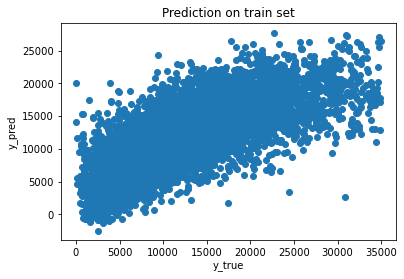

In [139]:
plt.scatter(y_train, y_train_pred)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Prediction on train set')
plt.show()

In [140]:
#Prediction using test
y_pred = model.predict(X_test_pca)
print( 'MSE: ' +str(mean_squared_error(y_test, y_pred)))
print('MAE: ' +str(mean_absolute_error(y_test, y_pred)))
print('MAPE: ' +str(mean_absolute_percentage_error(y_test, y_pred)))
print('R2_score: ' +str(r2_score(y_test, y_pred, multioutput='variance_weighted')))

MSE: 19060729.545167074
MAE: 3260.1751600745297
MAPE: 0.4187455276303087
R2_score: 0.5677242080576487


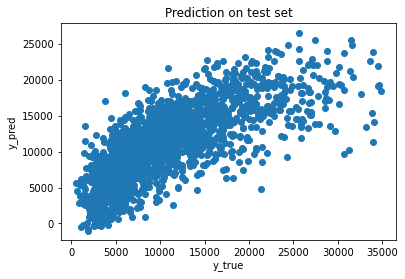

In [141]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Prediction on test set')
plt.show()

#### Random forest regressor

In [162]:
X_train.shape, X_test.shape

((10151, 267), (1792, 267))

In [163]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [144]:
#Base random forest model
regr = RandomForestRegressor(n_estimators = 100,max_depth = 5, min_samples_split = 5 ).fit(X_train, y_train)

In [145]:
#Prediction using train
print('Prediction using train')
y_train_pred = regr.predict(X_train)

print( 'MSE: ' +str(mean_squared_error(y_train, y_train_pred)))
print('MAE: ' +str(mean_absolute_error(y_train, y_train_pred)))
print('MAPE: ' +str(mean_absolute_percentage_error(y_train, y_train_pred)))
print('R2_score: ' +str(r2_score(y_train, y_train_pred, multioutput='variance_weighted')))

Prediction using train
MSE: 21434179.981228117
MAE: 3441.258644073328
MAPE: 0.6438286544090839
R2_score: 0.5163391825648214


In [146]:
#Prediction using test
print('Prediction using test')
y_pred = regr.predict(X_test)
print( 'MSE: ' +str(mean_squared_error(y_test, y_pred)))
print('MAE: ' +str(mean_absolute_error(y_test, y_pred)))
print('MAPE: ' +str(mean_absolute_percentage_error(y_test, y_pred)))
print('R2_score: ' +str(r2_score(y_test, y_pred, multioutput='variance_weighted')))

Prediction using test
MSE: 21917384.912998788
MAE: 3494.465983879952
MAPE: 0.4647687962847063
R2_score: 0.5029384946614409


In [164]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15, 20],
    'max_features': [10, 15, 20, 25],
    'min_samples_split' : [5,10],
    'min_samples_leaf' : [5,10],
    'n_estimators': [100, 200, 250, 500],
    'oob_score' : [True]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = 12, verbose = 3)

In [165]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    5.3s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   49.8s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:  2.4min
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 1280 out of 1280 | elapsed: 15.1min finished


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 25,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 500,
 'oob_score': True}

In [196]:
#regr = RandomForestRegressor(n_estimators = 300,max_depth = 15, max_features = 20,  min_samples_split = 5,min_samples_leaf= 5, oob_score = True ).fit(X_train, y_train)
regr = RandomForestRegressor(n_estimators = 500,max_depth = 20, max_features = 25,  min_samples_split = 5,min_samples_leaf= 5, oob_score = True ).fit(X_train, y_train)

In [197]:
#Prediction using train
print('Prediction using train')
y_train_pred = regr.predict(X_train)
print( 'MSE: ' +str(mean_squared_error(y_train, y_train_pred)))
print('MAE: ' +str(mean_absolute_error(y_train, y_train_pred)))
print('MAPE: ' +str(mean_absolute_percentage_error(y_train, y_train_pred)))
print('R2_score: ' +str(r2_score(y_train, y_train_pred, multioutput='variance_weighted')))

Prediction using train
MSE: 10184687.715897178
MAE: 2307.669044432945
MAPE: 0.44635951476110464
R2_score: 0.7701832124995243


In [198]:
#Prediction using test
print('Prediction using test')
y_pred = regr.predict(X_test)
print( 'MSE: ' +str(mean_squared_error(y_test, y_pred)))
print('MAE: ' +str(mean_absolute_error(y_test, y_pred)))
print('MAPE: ' +str(mean_absolute_percentage_error(y_test, y_pred)))
print('R2_score: ' +str(r2_score(y_test, y_pred, multioutput='variance_weighted')))

Prediction using test
MSE: 17947260.68554332
MAE: 3116.6875922407407
MAPE: 0.41080598708896165
R2_score: 0.5929764226676109


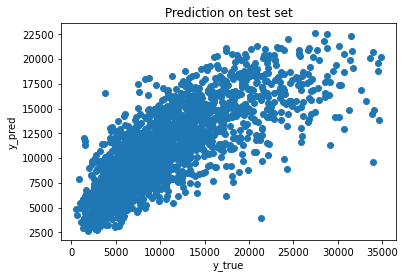

In [169]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Prediction on test set')
plt.show()

### KNN Regressor

In [170]:
from sklearn.neighbors import KNeighborsRegressor

In [192]:
nr_model = KNeighborsRegressor(n_neighbors=7, algorithm = 'kd_tree')
nr_model = nr_model.fit(X_train, y_train)

In [193]:
#Prediction using train
print('Prediction using train')
y_train_pred = nr_model.predict(X_train)
print( 'MSE: ' +str(mean_squared_error(y_train, y_train_pred)))
print('MAE: ' +str(mean_absolute_error(y_train, y_train_pred)))
print('MAPE: ' +str(mean_absolute_percentage_error(y_train, y_train_pred)))
print('R2_score: ' +str(r2_score(y_train, y_train_pred, multioutput='variance_weighted')))

Prediction using train
MSE: 18281552.44340861
MAE: 3045.3365185695993
MAPE: 0.4948688720332504
R2_score: 0.5874780091187575


In [194]:
#Prediction using test
print('Prediction using test')
y_pred = nr_model.predict(X_test)
print( 'MSE: ' +str(mean_squared_error(y_test, y_pred)))
print('MAE: ' +str(mean_absolute_error(y_test, y_pred)))
print('MAPE: ' +str(mean_absolute_percentage_error(y_test, y_pred)))
print('R2_score: ' +str(r2_score(y_test, y_pred, multioutput='variance_weighted')))

Prediction using test
MSE: 22255143.927478135
MAE: 3391.7602040816323
MAPE: 0.38677816510063107
R2_score: 0.4952785021557108


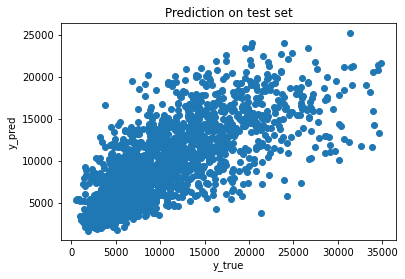

In [195]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Prediction on test set')
plt.show()